# Семинар: Бустинг

## 1. Бустинг: идея

На прошлом семинаре мы рассмотрели один из способов построения композиций моделей – бэггинг. Вспомним, что основная идея бэггинга состоит в том, чтобы агрегировать ответы большого числа независимых переобученных моделей, имеющих низкое смещение и большую дисперсию. Агрегация позволяет добиться значительного снижения дисперсии при сохранении низкого смещения. Бэггинг над деревьями, в котором при построении каждого дерева при разбиениях используются случайные подмножества признаков, называется случайным лесом.

На этом семинаре мы рассмотрим альтернативный бэггингу подход к построению композиции моделей – бустинг. Идея бустинга состоит в том, чтобы построить последовательность **базовых моделей**, каждая из которых **исправляет ошибки предыдущих**. Как и в случае бэггинга, ответ композиции получается агрегированием ответов базовых моделей.

### 1.1 Простой пример для понимания идеи.

Пусть мы решаем задачу регрессии на тренировочной выборке $(X, y)$. Мы обучаем модель $a(X)$, которая является композицией базовых моделей $b_n(X)$. Будем считать, что композиция строится простым суммированием ответов базовых моделей:

$$
a(X) = \sum_{n = 1}^{k} b_n(X).
$$

В качестве базовой модели будем использовать решающее дерево глубины один (decision stump).

**Важное замечание.** Считается, что одним из наиболее сильных и универсальных методов машинного обучения на данный момент является бустинг над деревьями, и во многих туториалах в Интернете рассматривается именно бустинг над деревьями. Следуя этой традиции (а также потому что при использовании деревьев картинки получаются более наглядными), в этом примере мы также рассмотрим бустинг над деревьями. Однако важно понимать, что бустинг – это подход, который может строиться над любыми моделями, на что мы также обратим внимание ниже.

Будем решать задачу при помощи минимизации среднеквадратичной ошибки:

$$
\dfrac{1}{\ell}\sum_{i = 1}^{\ell} (a(x_i) - y_i)^2 \to \min_a.
$$

В этом примере будем работать только с обучающей выборкой. Для построения композиции непосредственно используем идею бустинга.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

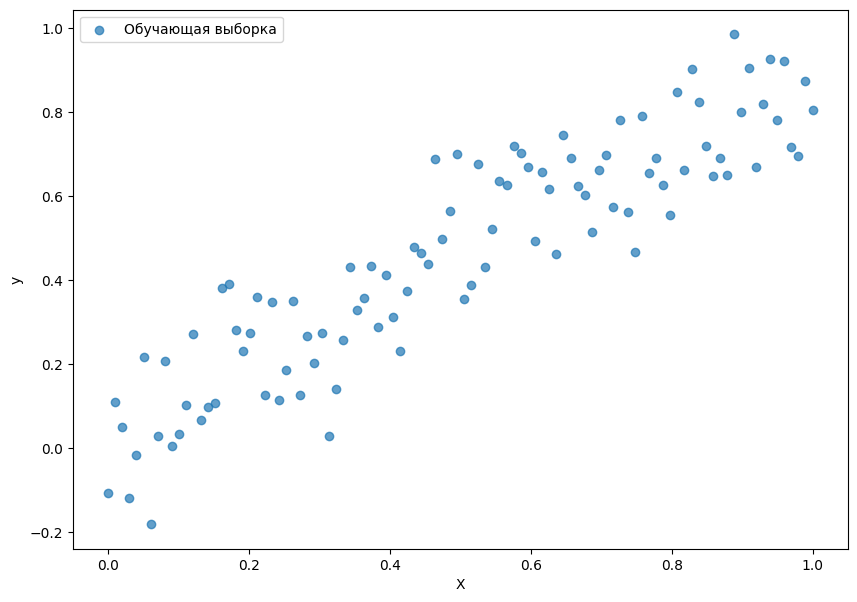

In [ ]:
# Генерация выборки
np.random.seed(123)
N = 100
X = np.linspace(0, 1, N).reshape(-1, 1)
y = np.sin(X)[:, 0] + np.random.normal(0, 0.1, size = N)

# Функция для визуализации выборки и предсказаний
def plot_sample_model(X, y, plot_predictions = False, y_pred = None, y_pred_label = None, loss = 'mse'):
    plt.figure(figsize = (10, 7))
    plt.scatter(X, y, label = 'Обучающая выборка', alpha = 0.7)
    if plot_predictions:
        plt.plot(X, y_pred, label = y_pred_label, c = 'r')
        if loss == 'mse':
            plt.title('MSE: ' + str(mean_squared_error(y, y_pred)))
        elif loss == 'mae':
            plt.title('MAE: ' + str(mean_absolute_error(y, y_pred)))
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend();

plot_sample_model(X, y, plot_predictions = False)

**Шаг 0.** Имеем пустую композицию решающих деревьев $a(X) = \{\}$.

In [ ]:
a = 0

**Шаг 1.** Обучим первое решающее дерево $DT_1$ и включим его в композицию: $a^{(1)}(X) = DT_1$. Получим предсказания композиции на обучающей выборке.

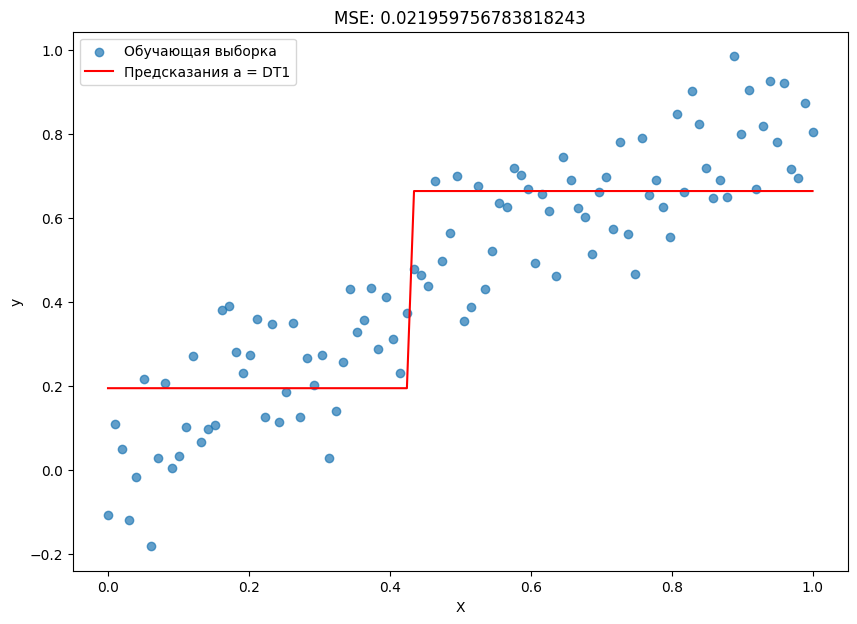

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Обучим решающее дерево глубины 1 и сделаем предсказания на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включим предсказания первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1')

**Шаг 2.** В качестве ошибок композиции будем использовать **остатки** –
расстояния от предсказаний композиции до истинных ответов:

$$
s^{(1)}(X) = y - a^{(1)}(X)
$$

Заметим, что $MSE$ – это усреднённая сумма квадратов остатков и что остатки являются естественным выражением ошибки: если мы прибавим остатки к ответам модели, то добьёмся нулевой среднеквадратичной ошибки. Таким образом, логично строить следующую модель так, чтобы она хорошо предсказывала остатки композиции: если мы прибавим предсказания второй модели (предсказанные остатки) к предскзазаниям первой, то добьёмся снижения ошибки.

In [ ]:
# Рассчитаем остатки
s1 = y - a

**Шаг 3.** Обучим второе решающее дерево $DT_2$, предсказывающее остатки. Добавим предсказания второго дерева в композицию: $a^{(2)}(X) = DT_1 + DT_2$. Получим предсказания композиции на обучающей выборке.

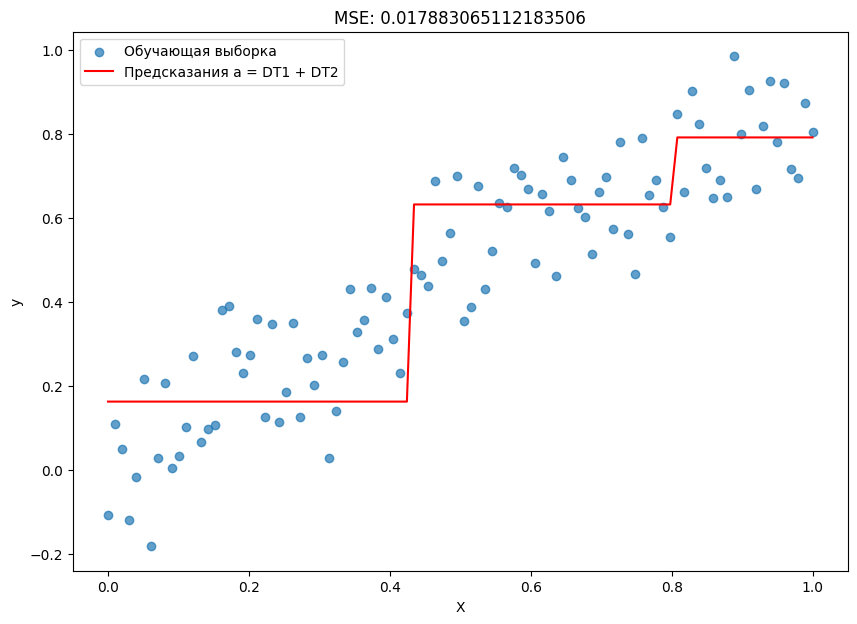

In [ ]:
# Обучим второе решающее дерево глубины 1, предсказывающее остатки
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Сделаем предсказания на обучающей выборке
dt2_pred = dt2.predict(X)

# Включим предсказания второго дерева в композицию (простым суммированием)
a += dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1 + DT2')

Как мы видим, решающая поверхность стала более сложной, и теперь она более точно приближает обучающую выборку.

**Шаги 4 – ...** Повторяем шаги 2-3, пока не надоест.

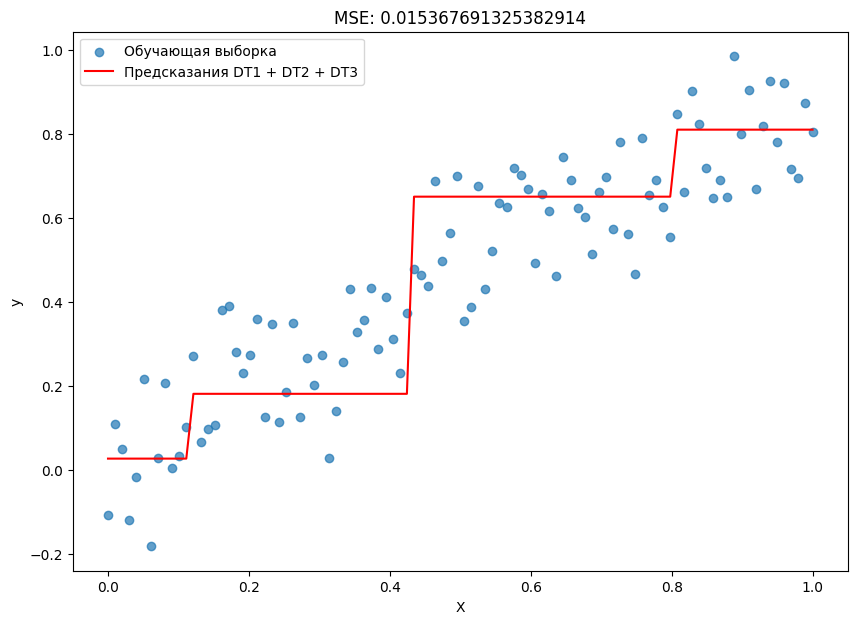

In [ ]:
# Рассчитаем остатки
s2 = y - a

# Обучим третье решающее дерево глубины 1, предсказывающее остатки
dt3 = DecisionTreeRegressor(max_depth = 1)
dt3.fit(X, s2)

# Сделаем предсказания на обучающей выборке
dt3_pred = dt3.predict(X)

# Включим предсказания третьего дерева в композицию (простым суммированием)
a += dt3_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания DT1 + DT2 + DT3')

Как мы видим, при добавлении базовых моделей решающая поверхность становится более сложной и всё точнее приближает обучающую выборку.

**Важный момент:** заметим, что при обучении очередной базовой модели композиция предыдущего шага считается фиксированной. Это означает, что обучение новой базовой модели не влияет на уже обученные модели, содержащиеся в композиции.

### 1.2 Бустинг над разными моделями.

При помощи функции `plot_boosting_results()` визуализируем решающие поверхности композиции, очередной базовой модели и остатки при добавлении базовых моделей.

Посмотрим, как выглядят решающие поверхности композиции, если в качестве базовой модели использовать
- решающее дерево
- линейную регрессию
- kNN-регрессор
- SVR (Support Vector Regression).

In [ ]:
def plot_boosting_results(base_estimator, n_estimators, X, y):

    fig, ax = plt.subplots(n_estimators, 3, figsize = (20, n_estimators * 5))

    # Остатки
    resid = []
    resid.append(y)

    # Предсказания моделей
    y_pred = []

    for i in range(n_estimators):
        # Обучение очередной базовой модели
        base_estimator.fit(X, resid[-1])

        # Предсказание базовой модели
        y_pred.append(base_estimator.predict(X))

        # Вычисление предсказания композиции
        a = np.sum(y_pred, axis = 0)

        # Вычисление остатка
        resid.append(y - a)

        # Предсказания композиции
        ax[i, 0].scatter(X, y, label = 'Обучающая выборка', alpha = 0.7)
        ax[i, 0].plot(X, a, c = 'red', lw = 3, label = 'Число деревьев: ' + str(i + 1))
        ax[i, 0].set_title('MSE: ' + str(mean_squared_error(y, a)))

        # Предсказания очередной модели
        ax[i, 1].scatter(X, y, label = 'Обучающая выборка', alpha = 0.7)
        ax[i, 1].plot(X, y_pred[-1], c = 'red', lw = 3)
        ax[i, 1].set_title('Предсказания модели ' + str(i + 1))

        ax[i, 2].scatter(X, resid[-1], alpha = 0.7, marker = 'v', c = 'orange')
        ax[i, 2].set_title('Остатки')

        ax[i, 0].legend()

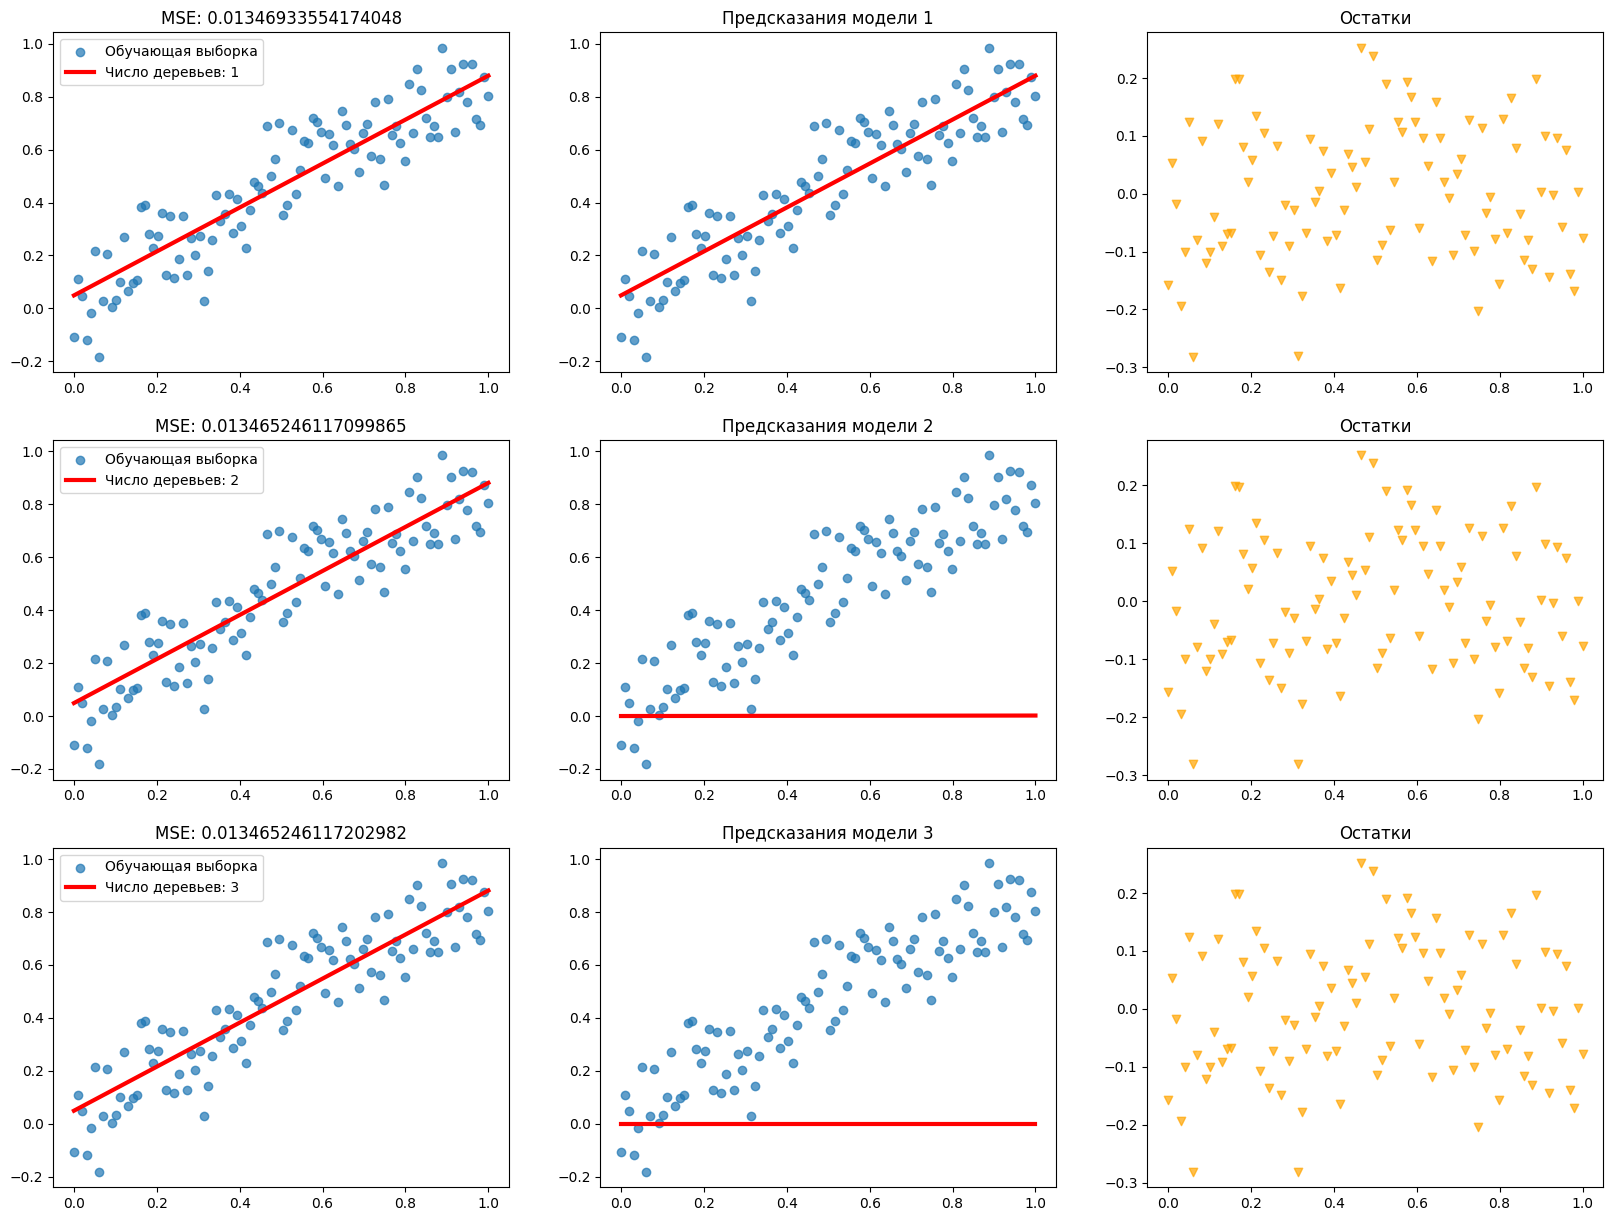

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

plot_boosting_results(SVR(kernel='linear'), n_estimators = 3, X = X, y = y)

## 2. Градиентный бустинг

Заметим, что в примере выше использование остатков как меры ошибки модели было оправданным, так как остатки непосредственно участвуют в расчёте $MSE$. Попробуем обобщить идею использования остатков на произвольную функцию потерь.

Будем решать ту же задачу, что и выше, но с использованием произвольной функции потерь $L(\cdot)$. Предположим, что каким-то образом мы уже обучили $N$ базовых моделей и построили композицию $a^{(N)}(X)$. Как построить $(N+1)$-ю базовую модель?

Заметим, что мы хотим выбрать $(N+1)$-ую базовую модель так, чтобы как можно сильнее уменьшить ошибку:

$$
\dfrac{1}{\ell}\sum_{i = 1}^{\ell} L[y_i, a^{N}(x_i) + b^{(N+1)}(x_i)] \to \min_{b^{(N+1)}},
$$

где $b^{(N+1)}(x_i)$ – предсказания новой базовой модели. Теперь заметим, что так как и $y_i$, и $a^{N}(x_i)$ фиксированы (обсуждали выше), то в сущности нам нужно найти числа $b^{(N+1)}(x_i) = s_i^{(N)}$, которые сильнее всего уменьшили бы функцию потерь:


$$
\dfrac{1}{\ell}\sum_{i = 1}^{\ell} L[y_i, a^{N}(x_i) + s^{(N)}_i] \to \min_{s^{(N)}_i}.
$$

**Замечание.** Заметьте, что теперь мы ищем просто числа $s^{(N)}_i$, которые сильнее всего уменьшили бы функцию.

После изучения градиентного спуска мы знаем, что вектор чисел, сильнее всего уменьшающих какую-то функцию – это антиградиент этой функции. Таким образом, в качестве чисел $s_i^{(N)}$ следует взять

$$
s_i^{(N)} = -\dfrac{\partial L(y, p)}{\partial p}
$$

в точке $p = a^{(N)}(x_i)$, то есть антиградиент функции потерь в точке ответов уже построенной композиции.

**Чек-пойнт.** Убедитесь, что вы понимаете, какие **числа**, нужно взять, чтобы решить задачу.

Итак, мы выяснили, какие числа нужно взять для уменьшения функции потерь на **обучающей выборке**. Вспомним, что мы определяли эти числа как $b^{(N+1)}(x_i) = s_i^{(N)}$, то есть ответы очередной базовой модели. Таким образом, нам нужно обучить очередную базовую модель так, чтобы она хорошо приближала антиградиент функции потерь в точке ответов уже построенной композиции – а это хорошо известная нам задача обучения с учителем. Обычно она решается путём минимизации $MSE$:

$$
b^{(N+1)}(x) = \arg\min_b \sum_{i = 1}^{\ell} (b(x_i) - s_i^{(N)})^2.
$$

**Важный момент:** заметим, что задача, описанная выше – это не изначальная задача! В этом и состоит магия градиентного бустинга: мы можем использовать любую функцию потерь, через неё вывести $s_i^{(N)}$, а затем просто решать задачу приближения при помощи $MSE$!

### 2.1 Продолжение простого примера для понимания идеи.

Повторим шаги из примера 1.1, используя градиентный бустинг, чтобы лучше разобраться в идее и провести параллели. Вспомним, что мы решали задачу регрессии при помощи минимизации $MSE$.

Нулевой и первый шаги в этих примерах совпадают.

**Шаг 0.** Имеем пустую композицию решающих деревьев $a(X) = \{\}$.

In [ ]:
a = 0

**Шаг 1.** Обучим первое решающее дерево $DT_1$ и включим его в композицию: $a^{(1)}(X) = DT_1$. Получим предсказания композиции на обучающей выборке.

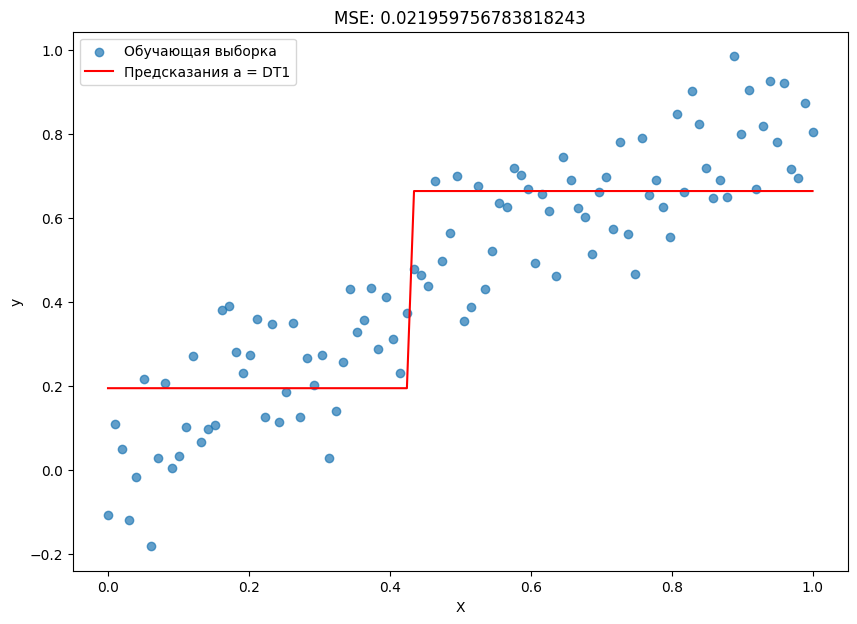

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Обучим решающее дерево глубины 1 и получим предсказания на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включим предсказания первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1')

**Шаг 2.** В примере 1.1 на этом шаге мы рассчитывали остатки. Здесь же мы должны рассчитать антиградиент функции потерь в точке ответов уже построенной композиции.

Вычислим градиент $MSE$

$$
L(y, p) = \dfrac{1}{2} \sum_{i = 1}^{\ell} (y_i - p_i)^2
$$

по $p_i$ в точке $p_i = a(x_i)$.



$$
\dfrac{\partial L(y, p)}{\partial p_i} = -(y_i - p_i) = \{p_i = a(x_i)\} = -(y_i - a(x_i)).
$$

Таким образом, антиградиент функции потерь равен:

$$
s_i = - (-(y_i - a(x_i))) = y_i - a(x_i),
$$

то есть в точности остаток в том виде, как мы определяли выше.

Таким образом, использование градиентного бустинга, если целевая функция – $MSE$, эквивалентно процедуре расчёта остатков, как мы это делали в примере 1.1, а сами остатки совпадают с антиградиентами $s_i$!

In [ ]:
# Рассчитаем антиградиент
s1 = y - a

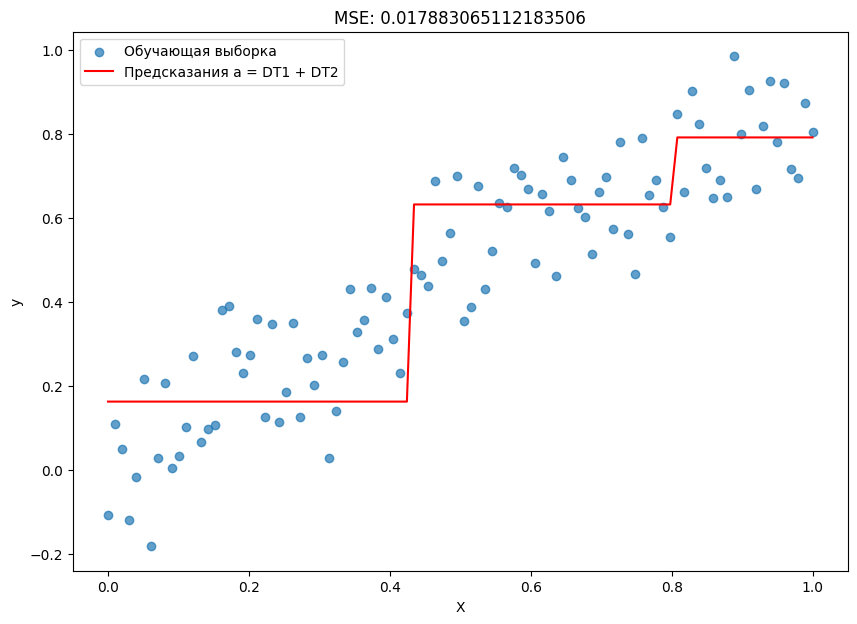

In [ ]:
# Обучим второе решающее дерево глубины 1, предсказывающее антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получим предсказания на обучающей выборке
dt2_pred = dt2.predict(X)

# Включим предсказания второго дерева в композицию (простым суммированием)
a += dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1 + DT2')

**Шаг 3 и далее.** Далее нам нужно обучить базовую модель, предсказывающую $s_i$. Но так как $s_i$ совпадают с остатками, этот и дальнейшие шаги будут совпадать с примером 1.1.

## 3. Функции потерь градиентного бустинга для регрессии и классификации

### 3.1 Регрессия.

В задачах регрессии в качестве целевой функции для композиции обычно берутся:

1. $MSE$, которую мы рассматривали ранее.

2. $MAE$:

$$
MAE(y, p) = \dfrac{1}{\ell} \sum_{i = 1}^{\ell} |y_i - p_i|
$$

Попробуем сделать шаг градиентного бустинга, используя в качестве функции потерь $MAE$.

**Задание:** рассчитайте $s_i$ для $MAE$.

**Решение:** $s_i^{(N)} = -\mathrm{sign}(a^{(N-1)}(x_i) - y_i)$.

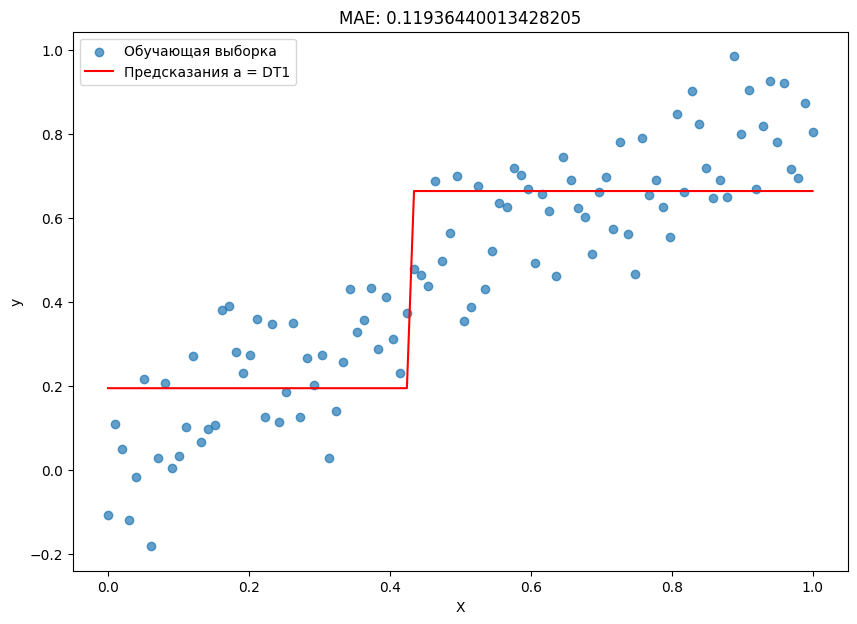

In [ ]:
# Инициализация
a = 0

# Обучим решающее дерево глубины 1 и получим предсказания на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включим предсказания первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1', loss = 'mae')

In [ ]:
# Рассчитаем антиградиент
s1 = -np.sign(a - y)

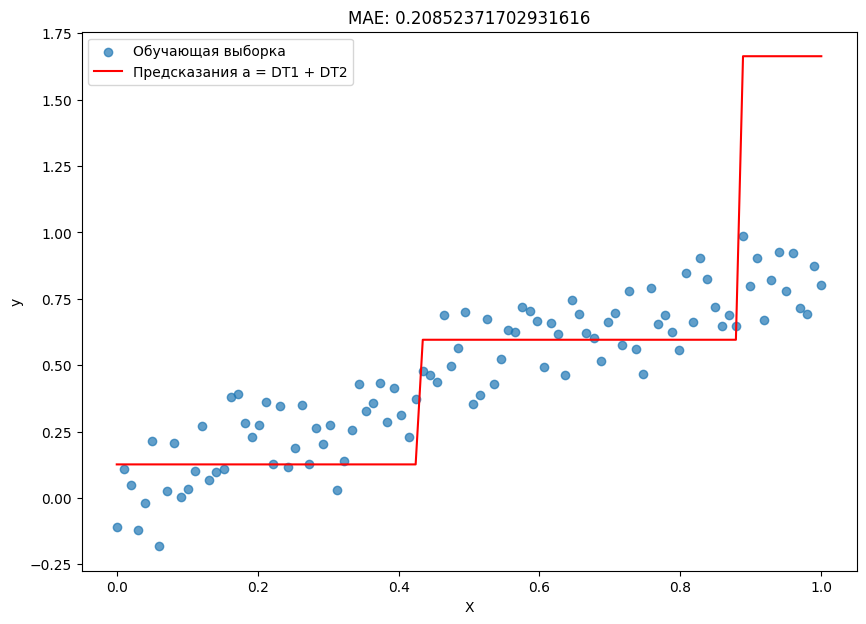

In [ ]:
# Обучим второе решающее дерево глубины 1, предсказывающее антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получим предсказания на обучающей выборке
dt2_pred = dt2.predict(X)

# Включим предсказаний второго дерева в композицию (простым суммированием)
a += dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a,
                  y_pred_label = 'Предсказания a = DT1 + DT2', loss = 'mae')

Заметим, что $MAE$ увеличилась, а решающая поверхность имеет "виток", уходящий за пределы обучающей выборки. Эту проблему мы решим позже.

### 3.2 Классификация.

В задачах бинарной классификации обычно используется логистическая функция потерь, с которой мы уже сталкивались в логистической регрессии.

$$
L(y, p) = \log(1 + e^{-yp}).
$$

Покажем, что в этом случае антиградиенты можно вычислить по формуле

$$
s^{(N)}_i = \dfrac{y_i}{1 + e^{y_ia^{(N-1)}(x_i)}}
$$

Попробуем сделать шаг градиентного бустинга в задаче бинарной классификации с логистической функцией потерь.

In [ ]:
from sklearn.datasets import load_iris

# Загрузка данных
data = load_iris()
X = data['data']
y = data['target']

# Перекодируем в задачу бинарной классификации
y[y == 2] = 1
set(y)

{np.int64(0), np.int64(1)}

In [ ]:
# Инициализация
a = 0

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

In [ ]:
def log_loss(y, y_pred):
    # Логистическая функция потерь
    return np.log(1 + np.exp(- y * y_pred)).mean()

In [ ]:
# Вычисление ошибки для одного дерева
log_loss(y, a)

np.float64(0.439890185198797)

In [ ]:
# Рассчитаем антиградиент
s1 = y / (1 + np.exp(y * a))

In [ ]:
# Обучим второе решающее дерево глубины 1, предсказывающее антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получим предсказания на обучающей выборке
dt2_pred = dt2.predict(X)

# Включим предсказаний второго дерева в композицию (простым суммированием)
a += dt2_pred

In [ ]:
# Вычислим ошибки для двух деревьев
log_loss(y, a)

np.float64(0.39621023915529535)

## 4. Особенности градиентного бустинга

###4.1 Построение композиции.

В примерах выше мы строили композицию моделей простым суммированием. Понятно, что в общем виде можно строить взвешенную сумму базовых моделей:

$$
a(X) = \sum_{n = 1}^{k} w_nb_n(X),
$$

где коэффициенты $w_n$ можно подобрать, например, при помощи градиентного спуска в задаче

$$
w_n = \arg\min_{w} \sum_{i = 1}^{\ell} L(y_i, a^{(N-1)}(x_i) + w \times b_N(x_i)),
$$

что имеет смысл, так как $b_N(x_i)$ уже обучена и фиксирована.

**Замечание:** длина шага является одним из ключевых параметров градиентного бустинга, и может очень сильно повлиять на его производительность. Подробнее об этом можно почитать, например, [здесь](https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/).

В нашем случае подбор правильного коэффициента поможет решить увеличение MAE в примере 3.1.

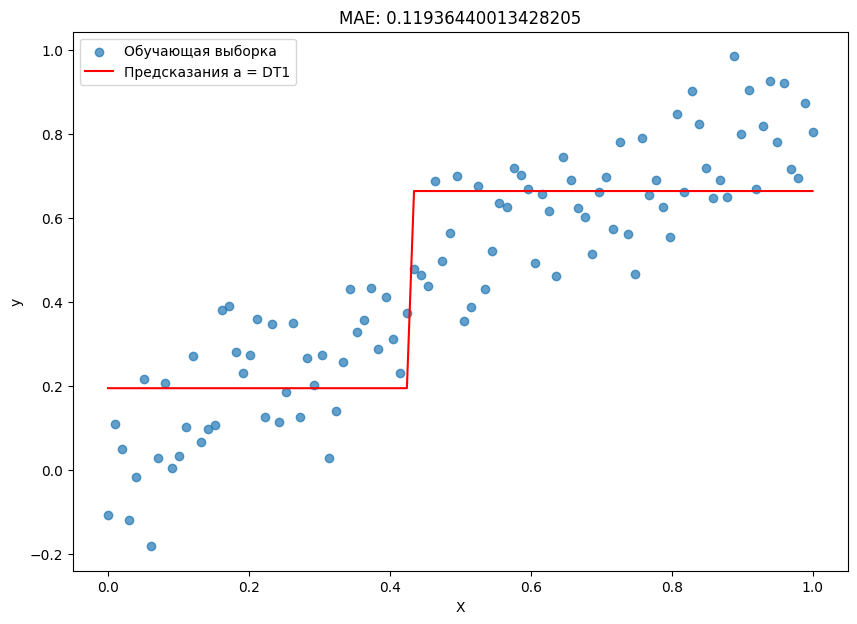

In [ ]:
# Инициализация
np.random.seed(123)
N = 100
X = np.linspace(0, 1, N).reshape(-1, 1)
y = np.sin(X)[:, 0] + np.random.normal(0, 0.1, size = N)
a = 0

# Обучим решающее дерево глубины 1 и получим предсказания на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включим предсказания первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1', loss = 'mae')

In [ ]:
# Вычислим антиградиент
s1 = -np.sign(a - y)

In [ ]:
# Подберем вес так, чтобы уменьшить MAE
w = 0.3

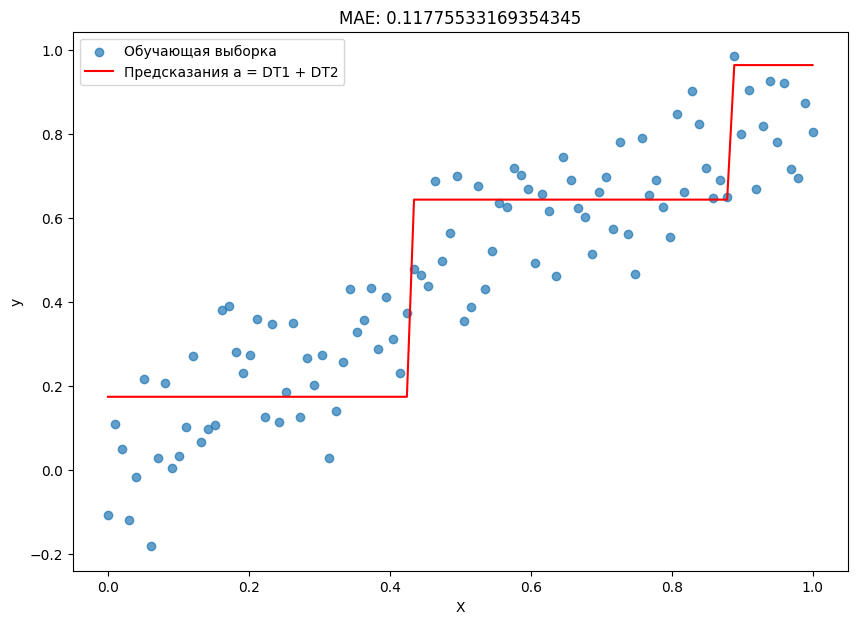

In [ ]:
# Обучим второе решающе дерево глубины 1, предсказывающее антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получим предсказания на обучающей выборке
dt2_pred = dt2.predict(X)

# Включим предсказания второго дерева в композицию (простым суммированием)
a += w * dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a,
                  y_pred_label = 'Предсказания a = DT1 + DT2', loss = 'mae')

### 4.2 Переобучение.

Вспомним, что в случае бэггинга увеличение числа базовых моделей не приводило к переобучению. Например, в случайном лесе ошибки на тренировочной и тестовой выборках выходили на плато, начиная с какого-то числа деревьев. Понятно, что бустинг не будет обладать этим свойством *по построению*: при добавлении новых базовых моделей композиция всё точнее будет приближать обучающую выборку, что в конечном итоге (зачастую быстро) может привести к переобучению. Из этого можно сделать вывод, что в случае бустинга ошибка на обучающей выборке в зависимости от числа деревьев является убывающей функцией, а ошибка на тестовой выборке, скорее всего, имеет U-образный вид. Убедимся в этом и сравним поведение ошибок и решающих поверхностей бустинга и случайного леса.

Будем использовать [реализацию бустинга](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) из `sklearn`, которая представляет собой градиентный бустинг над деревьями.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
# Генерация выборки
np.random.seed(123)
X = np.linspace(0, 1, 300).reshape(-1, 1)

def target(a):
    return a > 0.5

y = target(X) + np.random.normal(size = X.shape) * 0.1
y = y[:, 0]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

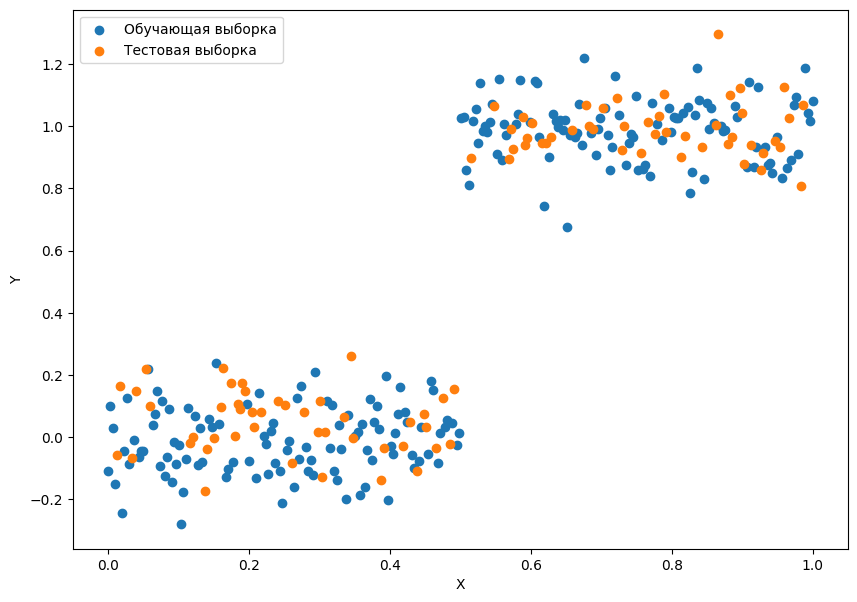

In [ ]:
# Визуализация выборки
plt.figure(figsize = (10, 7))
plt.scatter(X_train, y_train, label = 'Обучающая выборка')
plt.scatter(X_test, y_test, label = 'Тестовая выборка')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend();

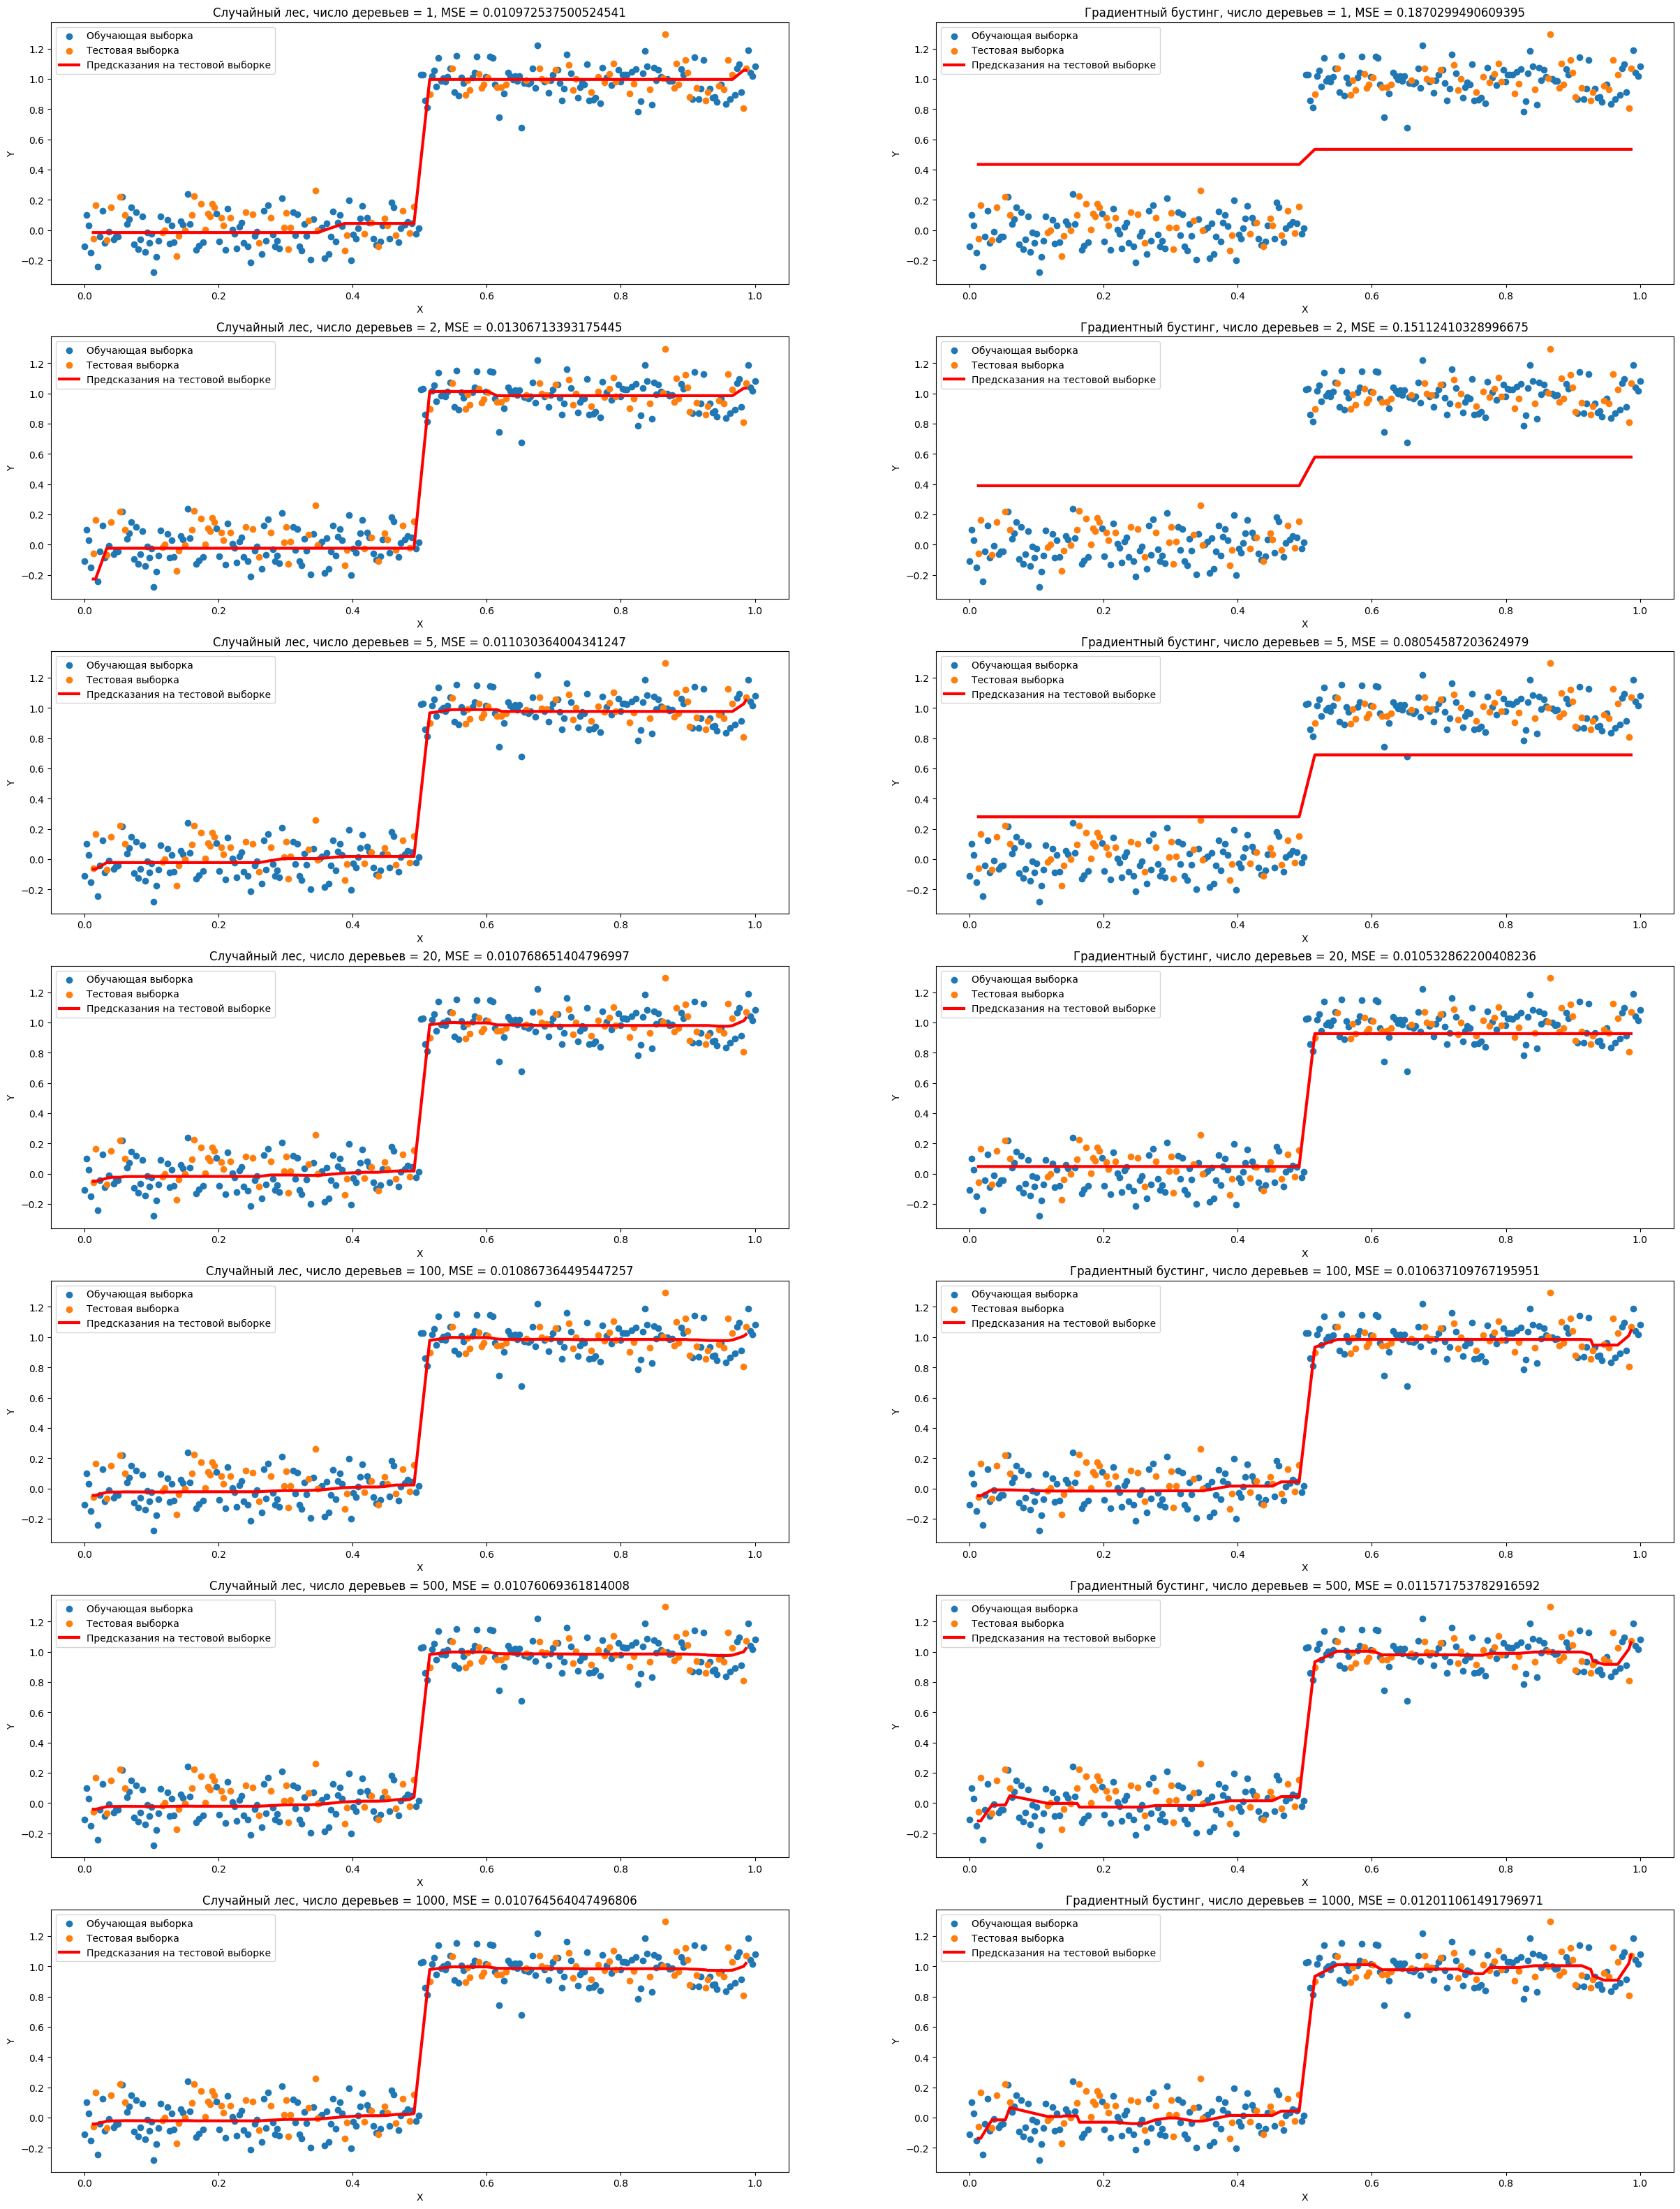

In [ ]:
# Визуализация решающих поверхностей
trees = [1, 2, 5, 20, 100, 500, 1000]

fig, ax = plt.subplots(len(trees), 2, figsize = (30, 40))

loss_rf_train = []
loss_gb_train = []
loss_rf_test = []
loss_gb_test = []

for i, ts in enumerate(trees):
    rf = RandomForestRegressor(n_estimators = ts, max_depth = 2)
    gb = GradientBoostingRegressor(n_estimators = ts, max_depth = 1, learning_rate = 0.1)

    rf.fit(X_train, y_train)
    ax[i, 0].scatter(X_train, y_train, label = 'Обучающая выборка')
    ax[i, 0].scatter(X_test, y_test, label = 'Тестовая выборка')
    ax[i, 0].plot(sorted(X_test), rf.predict(sorted(X_test)), lw = 3, c = 'red', label = 'Предсказания на тестовой выборке')
    ax[i, 0].set_xlabel('X')
    ax[i, 0].set_ylabel('Y')
    ax[i, 0].set_title('Случайный лес, число деревьев = ' + str(ts) + ', MSE = ' + str(mean_squared_error(y_test, rf.predict(X_test))))
    ax[i, 0].legend();

    loss_rf_train.append(mean_squared_error(y_train, rf.predict(X_train)))
    loss_rf_test.append(mean_squared_error(y_test, rf.predict(X_test)))

    gb.fit(X_train, y_train)
    ax[i, 1].scatter(X_train, y_train, label = 'Обучающая выборка')
    ax[i, 1].scatter(X_test, y_test, label = 'Тестовая выборка')
    ax[i, 1].plot(sorted(X_test), gb.predict(sorted(X_test)), lw = 3, c = 'red', label = 'Предсказания на тестовой выборке')
    ax[i, 1].set_xlabel('X')
    ax[i, 1].set_ylabel('Y')
    ax[i, 1].set_title('Градиентный бустинг, число деревьев = ' + str(ts) + ', MSE = ' + str(mean_squared_error(y_test, gb.predict(X_test))))
    ax[i, 1].legend();

    loss_gb_train.append(mean_squared_error(y_train, gb.predict(X_train)))
    loss_gb_test.append(mean_squared_error(y_test, gb.predict(X_test)))

Как мы видим, решающая поверхность случайного леса не изменяется при достижении определённого числа деревьев, в то время как для бустинга она становится всё более сложной.

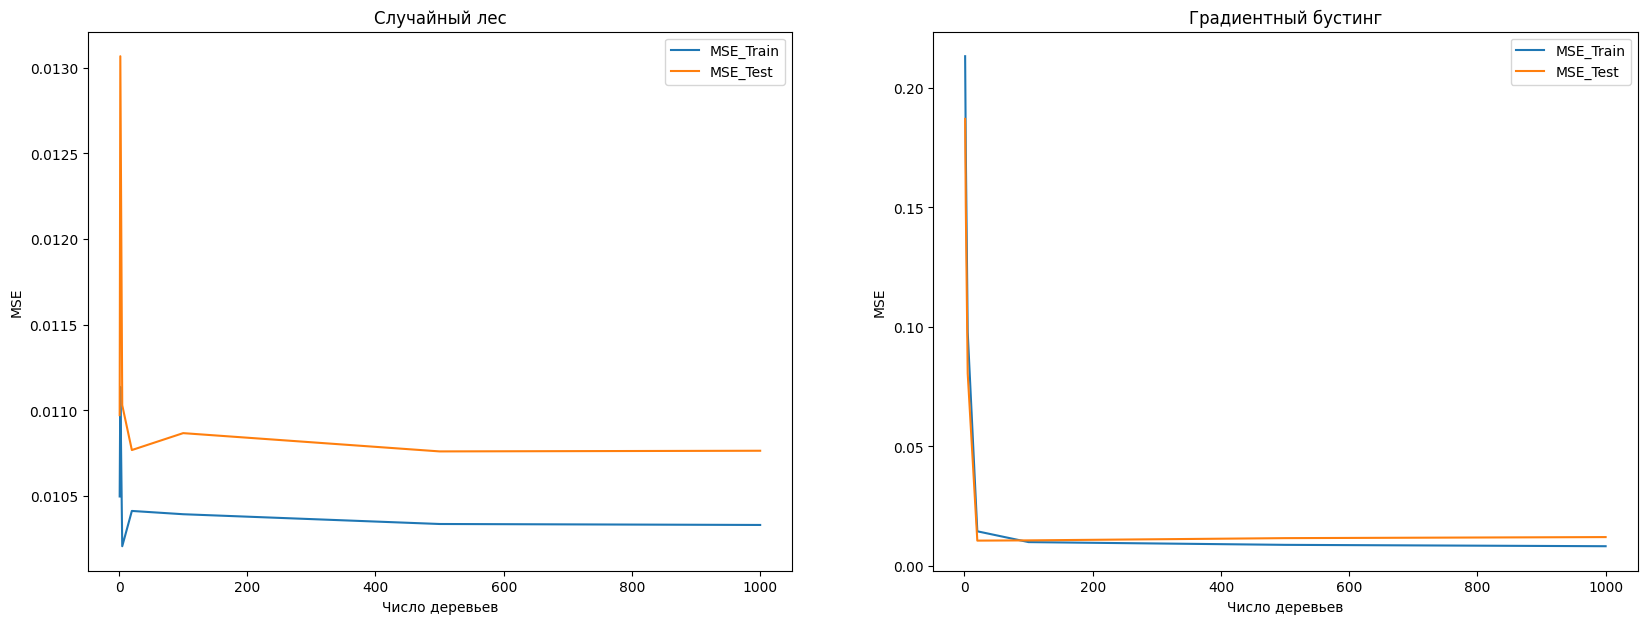

In [ ]:
# Визуализация ошибок
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

ax[0].plot(trees, loss_rf_train, label = 'MSE_Train')
ax[0].plot(trees, loss_rf_test, label = 'MSE_Test')
ax[0].set_xlabel('Число деревьев')
ax[0].set_ylabel('MSE')
ax[0].set_title('Случайный лес')
ax[0].legend()

ax[1].plot(trees, loss_gb_train, label = 'MSE_Train')
ax[1].plot(trees, loss_gb_test, label = 'MSE_Test')
ax[1].set_xlabel('Число деревьев')
ax[1].set_ylabel('MSE')
ax[1].set_title('Градиентный бустинг')
ax[1].legend();

Поведение ошибок для случайного леса совпадает с тем, которое мы видели на предыдущем семинаре. В случае бустинга ошибка на тренировочной выборке стабильно убывает, а на тестовой – возрастает, что вероятно говорит об (очень быстром) переобучении. Если же мы аккуратно подберём гиперпараметры для деревьев и длину шага, то сможем добиться типичной U-образной формы функции потерь на тестовой выборке.

В качестве способа регуляризации также может использоваться сокращение шага:

$$
a^{(N)}(X) = a^{(N-1)}(X) + \alpha w_N b^{(N)}(X),
$$

где $\alpha \in (0, 1]$ – темп обучения, или стохастический градиентный бустинг.

**Важный момент:** примеры выше демонстрируют, насколько быстро бустинг может переобучаться, и как в его случае важен подбор гиперпараметров. В связи с этим может сложиться ситуация, что градиентный бустинг с дефолтными параметрами показывает более плохое качество, чем, например, случайный лес с дефолтными параметрами, однако хорошо настроенный градиентный бустинг [обычно превосходит](https://www.quora.com/How-can-the-performance-of-a-Gradient-Boosting-Machine-be-worse-than-Random-Forests) случайный лес по качеству. Важна и конкретная реализация бустинга: например, [здесь](https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956), представлено очень хорошее сравнение различных имплементаций.

### 4.3 Пара слов о смещении и дисперсии.

Вспомним, что в случайном лесе в качестве базовых моделей мы брали переобученные деревья, мотивируя это тем, что бэггинг позволит сохранить низкое смещение и при этом уменьшить дисперсию. Бустинг по построению работает проивоположно: композиция обладает более низким, чем базовые модели, смещением, но такой же или большей дисперсией (ещё раз проговорите последовательность построения бустинга, и вы увидите, почему это так). Поэтому в качестве базовых моделей для бустинга обычно используются модели с высоким смещением и низкой дисперсией – как мы знаем, такие модели являются недообученными – например, неглубокие решающие деревья.

## 5. Тестирование реализаций градиентного бустинга

На прошлом семинаре мы выяснили, что случайный лес с дефолтными гиперпараметрами превосходит другие изученные нами алгоритмы на разных типах данных. Попробуем на тех же данных сравнить случайный лес и градиентный бустинг.



**! Модели могут обучаться долго.**

Сделаем бинарную классификацию на примере [Kaggle Predicting a Biological Response](https://www.kaggle.com/c/bioresponse/data?select=train.csv)

### 5.1 Реализация из sk-learn

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score

Загрузим данные

In [ ]:
!wget  -O 'kaggle_response.csv' -q 'https://www.dropbox.com/s/uha70sej5ugcrur/_train_sem09.csv?dl=1'

In [ ]:
data = pd.read_csv('kaggle_response.csv')
data

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0


Каждая строка представляет собой отдельную молекулу.

Датасет используется для предсказания биологического отклика молекулы — определения происходит ли некоторое заранее определённое биологическое событие (активность) при данной молекуле.

Activity (целевой признак) — бинарная метка: «да/нет» (1 если отклик был, 0 если нет).

Остальные колонки — дескрипторы молекулы (молекулярные характеристики, физико-химические свойства, топологические характеристики и др.).

In [ ]:
# разделение на обучающую и тестовую выборки

X = data.iloc[:, 1:]
y = data.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
feature_names = data.columns[1:]

Обучим градиентный бустинг и случайный лес с дефолтными параметрами и сравним их AUC ROC на тестовой выборке

In [ ]:
#время выполнения ~20 сек
# градиентный бустинг
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
pred_gb = gb.predict_proba(X_test) # предсказываем вероятности, так как смотрим AUC ROC

# случайный лес
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = rf.predict_proba(X_test)

In [ ]:
print(f'AUC ROC для градиентного бустинга с дефолтными параметрами: {roc_auc_score(y_test, pred_gb[:, 1])}')

AUC ROC для градиентного бустинга с дефолтными параметрами: 0.8532988097962921


In [ ]:
print(f'AUC ROC для случайного леса: {roc_auc_score(y_test, pred_rf[:, 1])}')

AUC ROC для случайного леса: 0.8749650314081534


Градиентный бустинг с другими гиперпараметрами

In [ ]:
#время выполнения +/- 5-10 минут
gb_tuned = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=10,
    loss='exponential'
)
gb_tuned.fit(X_train, y_train)
pred_gb_tuned = gb_tuned.predict_proba(X_test)

In [ ]:
print(f'AUC ROC для градиентного бустинга с другими гиперпараметрами: {roc_auc_score(y_test, pred_gb_tuned[:, 1])}')

AUC ROC для градиентного бустинга с другими гиперпараметрами: 0.8754673075455863


Применим XGboost, Catboost и LightGBM



In [ ]:
!pip install -q xgboost catboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

### 5.2 XGBoost

In [ ]:
#время выполнения +/- 1 минута

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    random_state=123,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict_proba(X_test)

In [ ]:
print(f'AUC ROC для XGBoost: {roc_auc_score(y_test, pred_xgb[:, 1])}')

AUC ROC для XGBoost: 0.8774700541695277


### 5.3 CatBoost

In [ ]:
#время выполнения +/- 1 минута

cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=123,
    verbose=False
)
cat.fit(X_train, y_train)
pred_cat = cat.predict_proba(X_test)


In [ ]:
print(f'AUC ROC для CatBoost: {roc_auc_score(y_test, pred_cat[:, 1])}')

AUC ROC для CatBoost: 0.8693541618982223


### 5.4 LightGBM

In [ ]:
#время выполнения +/- 1 минута

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary',
    random_state=123,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)
pred_lgbm = lgbm.predict_proba(X_test)


[LightGBM] [Info] Number of positive: 1422, number of negative: 1203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31913
[LightGBM] [Info] Number of data points in the train set: 2625, number of used features: 1579
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541714 -> initscore=0.167246
[LightGBM] [Info] Start training from score 0.167246


In [ ]:
print(f'AUC ROC для LightGBM: {roc_auc_score(y_test, pred_lgbm[:, 1])}')

AUC ROC для LightGBM: 0.8758901096106407


Сравним результаты

In [ ]:
models_auc = {
    "GB (default)": roc_auc_score(y_test, pred_gb[:, 1]),
    "RandomForest": roc_auc_score(y_test, pred_rf[:, 1]),
    "GB (tuned)": roc_auc_score(y_test, pred_gb_tuned[:, 1]),
    "XGBoost": roc_auc_score(y_test, pred_xgb[:, 1]),
    "CatBoost": roc_auc_score(y_test, pred_cat[:, 1]),
    "LightGBM": roc_auc_score(y_test, pred_lgbm[:, 1]),
}

print("Сравнение AUC ROC:")
for name, auc in models_auc.items():
    print(f"{name:12s}: {auc:.4f}")

Сравнение AUC ROC:
GB (default): 0.8533
RandomForest: 0.8750
GB (tuned)  : 0.8755
XGBoost     : 0.8775
CatBoost    : 0.8694
LightGBM    : 0.8759


## 6. Важность принаков

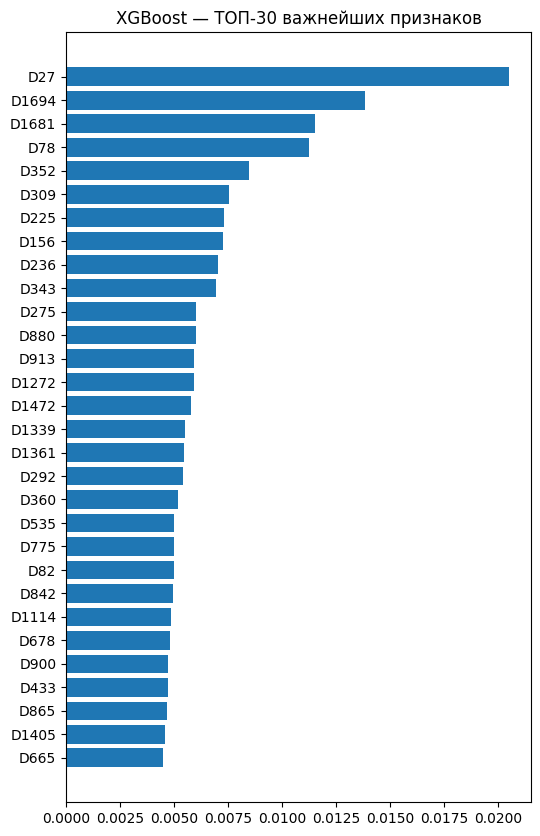

In [ ]:
importance_xgb = xgb.feature_importances_
top_idx = np.argsort(importance_xgb)[-30:]
top_feature_names = [feature_names[i] for i in top_idx]
plt.figure(figsize=(6, 10))
plt.barh(range(30), importance_xgb[top_idx])
plt.yticks(range(30), top_feature_names)
plt.title("XGBoost - ТОП-30 важнейших признаков")
plt.show()

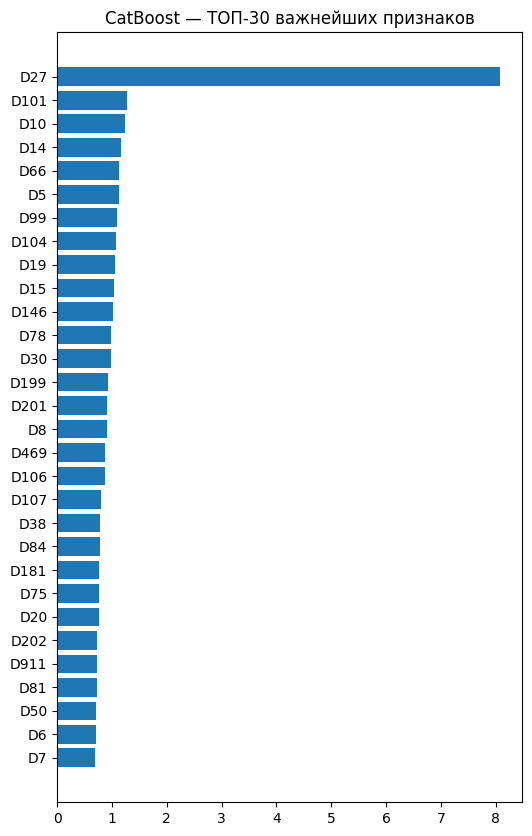

In [ ]:
importance_cat = cat.get_feature_importance()
top_idx = np.argsort(importance_cat)[-30:]
top_feature_names = [feature_names[i] for i in top_idx]

plt.figure(figsize=(6, 10))
plt.barh(range(30), importance_cat[top_idx])
plt.yticks(range(30), top_feature_names)
plt.title("CatBoost - ТОП-30 важнейших признаков")
plt.show()

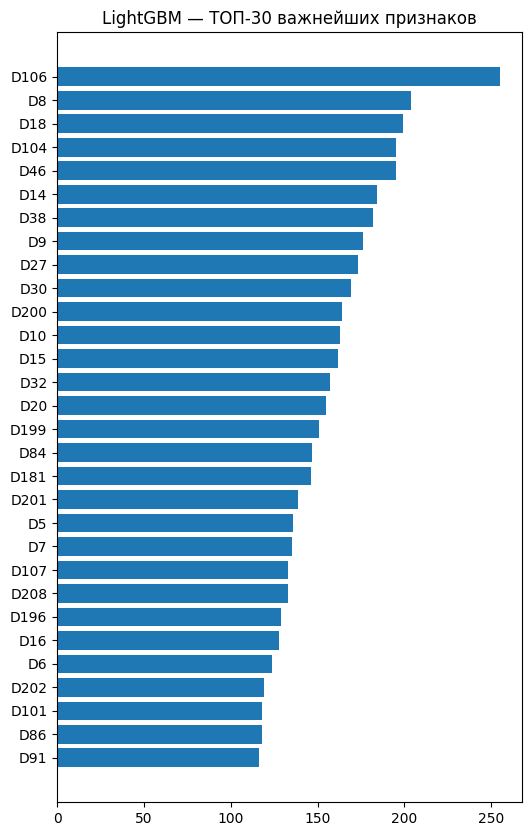

In [ ]:
importance_lgbm = lgbm.feature_importances_
top_idx = np.argsort(importance_lgbm)[-30:]
top_feature_names = [feature_names[i] for i in top_idx]


plt.figure(figsize=(6, 10))
plt.barh(range(30), importance_lgbm[top_idx])
plt.yticks(range(30), top_feature_names)
plt.title("LightGBM - ТОП-30 важнейших признаков")
plt.show()

## SHAP

Классические способы измерения важности признаков обладают существенным недостатком: непонятно, как именно каждый признак влияет на предсказание модели.

SHAP (SHapley Additive exPlanations) - это современный метод интерпретации моделей машинного обучения, основанный на значениях Шепли из теории кооперативных игр, который помогает объяснить, почему модель приняла то или иное решение, разложив предсказание на вклады отдельных признаков.

Оценивает:

* сколько в среднем добавляет каждый признак к предсказанию,
* как меняется вывод модели, если “включать” или “выключать” этот признак

In [ ]:
!pip install -q shap

In [ ]:
import shap

Посмотрим анализ для CatBoost

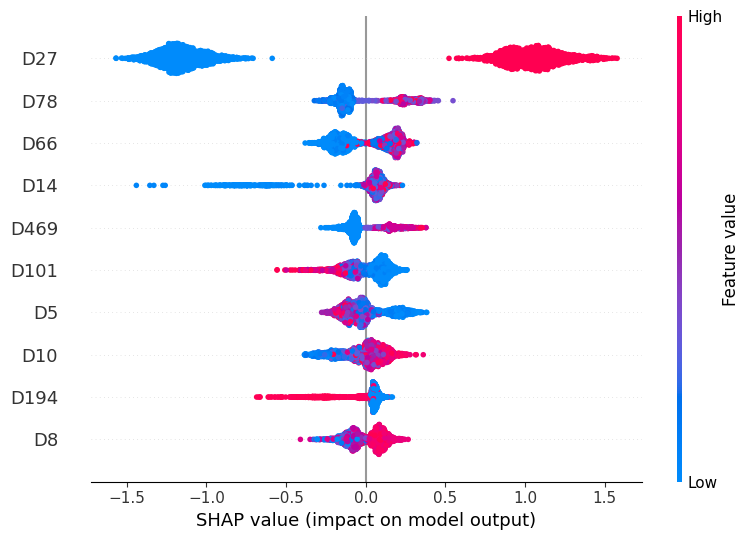

In [ ]:
explainer_cat = shap.Explainer(cat)
shap_values_cat = explainer_cat.shap_values(X_train)
rng = np.random.default_rng(123)


if isinstance(shap_values_cat, list):
    shap_values_cat_for_plot = shap_values_cat[1]
else:
    shap_values_cat_for_plot = shap_values_cat

shap.summary_plot(
    shap_values_cat_for_plot,
    X_train,
    max_display=10,
    rng = np.random.default_rng(123)
)

## 7. Подбор гиперпараметров

Модели бустинга очень мощные, но их качество сильно зависит от гиперпараметров: глубины деревьев, скорости обучения, числа итераций и других.
Если оставить параметры по умолчанию, модель может либо недообучиться, либо переобучиться и плохо работать на новых данных.

Подбор гиперпараметров помогает найти наиболее устойчивую и точную конфигурацию модели.

Познакомимся с тремя сопособами провести подбор гиперпараметров:
* RandomizedSearch на примере XGBoost,
* Optuna на примере LihtGBM,
* Встроенный grid-search у CatBoost.

###7.1. RandomizedSearch на примере XGBoost

Ссылка на документацию в [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [ ]:
#время выполнения ~15 минут
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    random_state=123,
)

param_dist_xgb = {
    "n_estimators": [200, 400, 600], # количество деревьев в ансамбле. Чем из больше, тем выше точность, но больше риск переобучения.
    "max_depth": [3, 5, 7, 9], # максимальная глубина деревьев. Глубокие деревья улавливают сложные зависимости, но могут переобучаться.
    "learning_rate": [0.01, 0.05, 0.1], # скорость обучения (шаг градиента). Низкая скорость делает обучение более "осторожным", требует больше деревьев.
    "subsample": [0.6, 0.8, 1.0], # доля тренировочных объектов, выбираемых случайно для каждого дерева. Уменьшает переобучение.
    "colsample_bytree": [0.6, 0.8, 1.0] # доля признаков, выбираемых случайно для каждого дерева. Также борется с переобучением.
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    cv=cv,
    scoring='roc_auc',
    verbose=1,
    random_state=123
)

search_xgb.fit(X_train, y_train)

best_xgb = search_xgb.best_estimator_
pred_xgb = best_xgb.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, pred_xgb)

print(f'XGBoost: лучший AUC на CV: {search_xgb.best_score_}')
print(f'XGBoost: AUC на тесте: {auc_xgb}')
print(f'Лучшие параметры: {search_xgb.best_params_}')


Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost: лучший AUC на CV: 0.8632971018305152
XGBoost: AUC на тесте: 0.8783538058543781
Лучшие параметры: {'subsample': 0.6, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


### 7.2. Optuna на примере LightGBM

Ссылка на [документацию](https://optuna.readthedocs.io/en/stable/)

In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.9 MB/s eta 0:00:00


In [ ]:
# время выполнения ~ 7 минут
import optuna
from sklearn.model_selection import cross_val_score

def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800), # количество деревьев. Больше — лучше точно описывает данные, но риск переобучения выше.
        "num_leaves": trial.suggest_int("num_leaves", 16, 128), # максимальное число листьев в дереве LightGBM. Основной параметр, отвечающий за сложность модели.
        "max_depth": trial.suggest_int("max_depth", 3, 12), # ограничение глубины дерева. Нужно, чтобы не дать num_leaves разрастись слишком сильно.
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True), # скорость обучения. Низкие значения делают обучение более устойчивым.
        "subsample": trial.suggest_float("subsample", 0.6, 1.0), # доля обучающей выборки, используемая для каждого дерева. Помогает бороться с переобучением.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0), # доля признаков, которая случайно выбирается при построении каждого дерева.
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50), # минимальное число объектов в листе. Увеличение этого параметра уменьшает вариативность и снижает переобучение.
        "random_state": 123,
        "verbose": -1
    }

    model = LGBMClassifier(**params)

    scores = cross_val_score(
        model,
        X_train, y_train,
        cv=3,
        scoring="roc_auc",
    )

    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective_lgb, n_trials=30)

print(f'LightGBM: лучший AUC на CV: {study.best_value}')
print(f'Лучшие параметры LightGBM: {study.best_params}')

best_lgb = LGBMClassifier(**study.best_params)
best_lgb.fit(X_train, y_train)
pred_lgb = best_lgb.predict_proba(X_test)[:, 1]
auc_lgb = roc_auc_score(y_test, pred_lgb)

print(f'LightGBM: AUC на тесте: {auc_lgb}')


[I 2025-11-24 11:43:18,206] A new study created in memory with name: no-name-89e86938-6789-4e8d-b302-fc8d95edb1ed
[I 2025-11-24 11:44:05,251] Trial 0 finished with value: 0.8529976044417787 and parameters: {'n_estimators': 651, 'num_leaves': 81, 'max_depth': 10, 'learning_rate': 0.11492119056297173, 'subsample': 0.7878294347336661, 'colsample_bytree': 0.8040618787633481, 'min_child_samples': 39}. Best is trial 0 with value: 0.8529976044417787.
[I 2025-11-24 11:44:16,479] Trial 1 finished with value: 0.8559034902195988 and parameters: {'n_estimators': 387, 'num_leaves': 52, 'max_depth': 8, 'learning_rate': 0.044243298015582674, 'subsample': 0.8135060284438904, 'colsample_bytree': 0.7462841267322553, 'min_child_samples': 26}. Best is trial 1 with value: 0.8559034902195988.
[I 2025-11-24 11:44:37,995] Trial 2 finished with value: 0.8562963196790022 and parameters: {'n_estimators': 327, 'num_leaves': 73, 'max_depth': 11, 'learning_rate': 0.02135561927431515, 'subsample': 0.6312781742186816

LightGBM: лучший AUC на CV: 0.8594091424041865
Лучшие параметры LightGBM: {'n_estimators': 491, 'num_leaves': 64, 'max_depth': 8, 'learning_rate': 0.015366827962681226, 'subsample': 0.6513048976069229, 'colsample_bytree': 0.6364986575623885, 'min_child_samples': 44}
[LightGBM] [Info] Number of positive: 1422, number of negative: 1203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30969
[LightGBM] [Info] Number of data points in the train set: 2625, number of used features: 1309
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541714 -> initscore=0.167246
[LightGBM] [Info] Start training from score 0.167246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

### 7.3. Встроенный grid-search у CatBoost

In [ ]:
#время выполнения ~
cat = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC:hints=skip_train~false",
    random_seed=123,
    verbose=False
)

param_grid_cat = {
    "depth": [4, 6, 8],
    "learning_rate": [0.03, 0.1],
    "iterations": [300, 500, 800]
}

cv_params = {
    "X": X_train,
    "y": y_train,
    "cv": 3,
    "shuffle": True,
    "partition_random_seed": 123
}

grid_result = cat.grid_search(
    param_grid_cat,
    **cv_params,
    verbose=False
)

print(f'CatBoost: лучший результат на CV: {grid_result["cv_results"]["test-AUC-mean"]}')
print(f'Лучшие параметры CatBoost: {grid_result["params"]}')

best_cat = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=123,
    verbose=False,
    **grid_result["params"]
)

best_cat.fit(X_train, y_train)
pred_cat = best_cat.predict_proba(X_test)[:, 1]
auc_cat = roc_auc_score(y_test, pred_cat)

print(f'CatBoost: AUC на тесте: {auc_cat}')



bestTest = 0.8342814815
bestIteration = 295


bestTest = 0.841037037
bestIteration = 291


bestTest = 0.8399111111
bestIteration = 468


bestTest = 0.8464592593
bestIteration = 499


bestTest = 0.8448592593
bestIteration = 799


bestTest = 0.8496592593
bestIteration = 729


bestTest = 0.8465777778
bestIteration = 297


bestTest = 0.8487703704
bestIteration = 180


bestTest = 0.8542814815
bestIteration = 498


bestTest = 0.8507259259
bestIteration = 335


bestTest = 0.8554666667
bestIteration = 518


bestTest = 0.8511555556
bestIteration = 776


bestTest = 0.8472888889
bestIteration = 293


bestTest = 0.8497185185
bestIteration = 279


bestTest = 0.8547259259
bestIteration = 480


bestTest = 0.8505777778
bestIteration = 467


bestTest = 0.8556148148
bestIteration = 573


bestTest = 0.851362963
bestIteration = 763

Training on fold [0/3]

bestTest = 0.8659259025
bestIteration = 504

Training on fold [1/3]

bestTest = 0.8697980786
bestIteration = 308

Training on fold [2/3]

bestTest = 0

In [ ]:
results = pd.DataFrame({
    "model": ["XGBoost", "CatBoost", "LightGBM"],
    "auc_cv": [search_xgb.best_score_, grid_result["cv_results"]["test-AUC-mean"], study.best_value],
    "auc_test": [auc_xgb, auc_cat, auc_lgb]
})

display(results.sort_values("auc_test", ascending=False))


,model,auc_cv,auc_test
1,CatBoost,"[0.7804206081140328, 0.7880641223944358, 0.793...",0.881456
0,XGBoost,0.863297,0.878354
2,LightGBM,0.859409,0.873589
